In [141]:
using Pkg
Pkg.update()
Pkg.add("TestImages"); Pkg.add("Images"); Pkg.add("ImageView")
using Knet
using Random
using IterTools: ncycle
Pkg.add("PyCall")
# using TestImages,Images, ImageView
using PyCall
pickle = pyimport("pickle")
numpy = pyimport("numpy")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


PyObject <module 'numpy' from '/usr/local/lib/python3.7/site-packages/numpy/__init__.py'>

In [218]:
using Base.Iterators

In [143]:
Pkg.add("Images"); using Images; Pkg.add("Colors"); using Colors

 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


In [6]:
function prepare_sentence(sent, to_ix)
    sent = split(strip(lowercase(sent),' '))
    idxs = [to_ix[w] for w in sent]
    return idxs
end

prepare_sentence (generic function with 1 method)

In [7]:
function mask!(a,pad)
    x,y = size(a)
    for i = 1:x
        for j = 1:y
            if a[i, j] == pad
                a[i, j] = 0
            end
        end
    end
    return a
end

mask! (generic function with 1 method)

In [8]:
function mypickle(filename, obj)
    out = open(filename,"w")
    pickle.dump(obj, out)
    close(out)
 end

function myunpickle(filename)
    r = nothing
    @pywith pybuiltin("open")(filename,"rb") as f begin
        r = pickle.load(f)
    end
    return r
end

myunpickle (generic function with 1 method)

In [9]:
true_dataset = myunpickle("dataset/dataset_true.pickle")

#true_dataset = true_dataset[1:30]

wdict = Dict()
w2i(x) = get!(wdict, x, 1+length(wdict))
UNK = w2i("<unk>")
EOS = w2i("<eos>")
#w2i(x) = get(wdict, x, UNK), for test time

2

In [10]:
dataset_false = []
false_count = 0
while(false_count < 347)
    index1 = rand(1:1:347)
    index2 = rand(1:1:347)
    
    if(true_dataset[index1][2] != true_dataset[index2][2])
        newdata = (true_dataset[index1][1], true_dataset[index2][2])
        newdata2 = (true_dataset[index2][1], true_dataset[index1][2])
        push!(dataset_false, newdata); push!(dataset_false, newdata2)
        global false_count += 2
    end
end
dataset = copy(append!(true_dataset, dataset_false))
summary(dataset)

"695-element Array{Tuple{Tuple{Array{UInt8,3},Array{UInt8,3}},String},1}"

In [11]:
y_truth = ones(Int32,length(dataset))
true_labels = ones(Int32,347)
y_truth = y_truth[348:end].+1
append!(true_labels, y_truth)
y_truth = copy(true_labels)
println(summary(y_truth))

rng = Random.seed!(0)
y_truth = shuffle(rng, y_truth)
rng = Random.seed!(0)
dataset = shuffle(rng, dataset)
println(summary(dataset))

695-element Array{Int32,1}
695-element Array{Tuple{Tuple{Array{UInt8,3},Array{UInt8,3}},String},1}


In [12]:
VOCAB_SIZE = length(wdict)
BATCHSIZE = 40

40

In [13]:
images = []
labels = []
for i in 1:length(dataset)
    (f1,f2), sent = dataset[i]
    both_frames = hcat(f1,f2)
    both_frames = Float32.(both_frames)
    wordids = w2i.(split(sent))
    push!(labels, wordids)
    push!(images,both_frames)
#    image_batch = reshape(cat1d(images...), (210,320,3,length(true_dataset)))
end

In [14]:
mutable struct Conv 
    w 
    b 
    f_activation
    p_drop
    f_pool
end
(c::Conv)(x) = c.f_activation.(c.f_pool(conv4(c.w, dropout(x,c.p_drop)) .+ c.b))


Conv(w1::Int,w2::Int,cx::Int,cy::Int;f=relu, pdrop=0, f_pool=pool) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop, f_pool)

Conv

In [15]:
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

Dense

In [16]:
struct Projection; w; b; f; p; end
(d::Projection)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Projection(i::Int,o::Int,f=relu;pdrop=0) = Projection(param(o,i), param0(o), f, pdrop)

Projection

In [17]:
struct Embed; w; end
Embed(vocabsize::Int,embedsize::Int) = Embed(param(embedsize,vocabsize))
(e::Embed)(x) = e.w[:,x]

In [18]:
mutable struct frame_head
    conv1
    conv2
    conv3
    conv4
    fc
    output
end

function frame_head(w1,c1,w2,c2,w3,c3,w4,c4,hidden, outdims)
    conv1 = Conv(w1, w1, 3, c1)
    conv2 = Conv(w2, w2, c1, c2)
    conv3 = Conv(w3, w3, c2, c3)
    conv4 = Conv(w4, w4, c3, c4; f_pool = identity)
    fc = Dense(47040, hidden)
    output = Dense(hidden, outdims)
    frame_head(conv1, conv2, conv3, conv4, fc, output)
end
    

function (f::frame_head)(x)
    f.output(f.fc(f.conv4(f.conv3(f.conv2(f.conv1(x))))))
end

In [19]:
mutable struct sentence_head
    embed
    encoder
end


function sentence_head(vocabsize::Int, embeddingsize::Int, hiddensize::Int)
    embed = Embed(vocabsize, embeddingsize)
    encoder = RNN(embeddingsize, hiddensize, rnnType = :lstm, h = 0)
    sentence_head(embed, encoder)
end

sentence_head

In [20]:
function (s::sentence_head)(x)
    src_embed_tensor = s.embed(x)
    s.encoder.h = 0
    s.encoder.c = 0
    y_enc = s.encoder(src_embed_tensor)
end

In [21]:
function seqbatch(sentences)
    batchsize = size(sentences, 1)
    maxlength = findmaxlength(sentences)
    for sent in sentences
        if(length(sent) < maxlength)
            for i = 1:maxlength-length(sent)
                push!(sent, 2)
            end
        end
    end
    permutedims(reshape(cat1d(sentences...), (maxlength,BATCHSIZE)), (2,1))
end

seqbatch (generic function with 1 method)

In [22]:
mutable struct bimodalEncoder
    fh
    sh
end


function bimodalEncoder(w1,c1,w2,c2,w3,c3,w4,c4,hidden, outdims, vocabsize, embeddingsize, hiddensize)
    fh = frame_head(w1,c1,w2,c2,w3,c3,w4,c4,hidden, outdims)
    sh = sentence_head(vocabsize, embeddingsize, hiddensize)
    bimodalEncoder(fh, sh)
end

function (b::bimodalEncoder)(image, label, y_truth)
    trans_nll(cosine_similarity(b, image_batch, seqbatch(labels)), y_truth)
end


function (b::bimodalEncoder)(x)
    
    images = []
    labels = []
   
    for i in 1:length(x)
        (f1,f2), sent = x[i]
        both_frames = hcat(f1,f2)
        both_frames = Float32.(both_frames)
        wordids = w2i.(split(sent))
        push!(labels, wordids)
        push!(images,both_frames)
    end
    image_batch = reshape(cat1d(images...), (210,320,3,length(x)))
    if (gpu()>=0)
        image_batch = KnetArray(image_batch)
    end
    cosine_similarity(b, image_batch, seqbatch(labels))
end



function(b::bimodalEncoder)(x,y) 
    images = []
    labels = []
    for i in 1:length(x)
        (f1,f2), sent = x[i]
        both_frames = hcat(f1,f2)
        both_frames = Float32.(both_frames)
        wordids = w2i.(split(sent))
        push!(labels, wordids)
        push!(images,both_frames)
        
    end
    image_batch = reshape(cat1d(images...), (210,320,3,length(x)))
    if (gpu()>=0)
        image_batch = KnetArray(image_batch)
    end
    
    trans_nll(cosine_similarity(b, image_batch, seqbatch(labels)), y)
end

function (b::bimodalEncoder)(d::Knet.Data) 
    Knet.mean(b(x,y) for (x,y) in d)
end

In [28]:
function findmaxlength(sentences)
    maxsize = 0
    count = 0
    for sent in sentences
        count = count + 1
        if(length(sent) > maxsize)
            
            maxsize = length(sent)
        end
    end
    return maxsize
end

findmaxlength (generic function with 1 method)

In [29]:
function cosine_similarity(b::bimodalEncoder, frame_pairs, sentences)
    sum( b.sh(sentences)[:,:,end] .*  b.fh(frame_pairs), dims = 1) ./ (sqrt.(sum( b.sh(sentences)[:,:,end].^2, dims = 1)) .* sqrt.(sum( b.fh(frame_pairs).^2, dims = 1)))
end

cosine_similarity (generic function with 1 method)

In [30]:
function convertsimilaritytoprobdist(cos_similarity)
    vcat(0.5.+((cos_similarity .* sqrt.(1 .- cos_similarity.^2))./π) + (asin.(cos_similarity)./π), 1 .- (0.5.+((cos_similarity .* sqrt.(1 .- cos_similarity.^2))./π) + (asin.(cos_similarity)./π)))
end

convertsimilaritytoprobdist (generic function with 1 method)

In [31]:
#function trans_nll(cos_similarity, y_truth)
#    nll(vcat((cos_similarity .+ 1)./2, 1 .- (cos_similarity .+ 1)./2), y_truth)
#end
  
function trans_nll(cos_similarity, y_truth)
    nll(convertsimilaritytoprobdist(cos_similarity),y_truth)
end

trans_nll (generic function with 1 method)

In [32]:
dtrn = minibatch(dataset[1:550], y_truth[1:550], BATCHSIZE; shuffle = true)
dtst = minibatch(dataset[551:end], y_truth[551:end], BATCHSIZE)
summary(first(dtrn))

"Tuple{Array{Tuple{Tuple{Array{UInt8,3},Array{UInt8,3}},String},1},Array{Int32,1}}"

In [33]:
b = bimodalEncoder(5,32,5,32,4,64,3,64, 10, 10, length(wdict), 12, 10)

bimodalEncoder(frame_head(Conv(P(Array{Float32,4}(5,5,3,32)), P(Array{Float32,4}(1,1,32,1)), NNlib.relu, 0, Knet.pool), Conv(P(Array{Float32,4}(5,5,32,32)), P(Array{Float32,4}(1,1,32,1)), NNlib.relu, 0, Knet.pool), Conv(P(Array{Float32,4}(4,4,32,64)), P(Array{Float32,4}(1,1,64,1)), NNlib.relu, 0, Knet.pool), Conv(P(Array{Float32,4}(3,3,64,64)), P(Array{Float32,4}(1,1,64,1)), NNlib.relu, 0, identity), Dense(P(Array{Float32,2}(10,47040)), P(Array{Float32,1}(10)), NNlib.relu, 0), Dense(P(Array{Float32,2}(10,10)), P(Array{Float32,1}(10)), NNlib.relu, 0)), sentence_head(Embed(P(Array{Float32,2}(12,21))), LSTM(input=12,hidden=10)))

In [ ]:
b = Knet.load("bimodalv3.jld2", "model")
# tup = (image_batch, labels, y_truth)
# list = [tup]
# summary(list)
# loss_before = trans_nll(cosine_similarity(b, image_batch, seqbatch(labels)), y_truth)
# println(summary(loss_before))
println("Train error before training is: ", b(dtrn))
println("Test error before training is: ", b(dtst))

In [ ]:
a = adam(b, take(cycle(dtrn),550))
progress!(a)

In [ ]:
# loss_after = trans_nll(cosine_similarity(b, image_batch, seqbatch(labels)), y_truth)
# # loss_after = sum(cosine_similarity(b, image_batch, seqbatch(labels)))
# println("loss before: ", loss_before, "loss after: ", loss_after)
# # println(cosine_similarity(b, image_batch, seqbatch(labels)))

In [ ]:
println("Train error after training is: ", b(dtrn))
println("Test error after training is: ", b(dtst))

In [131]:
function accuracy(dataset, model)
    total_count = 0
    total_correct = 0
    for batch in dataset
        probdist = convertsimilaritytoprobdist(model(batch[1]))
        preds = vec(map(x->x[1], argmax(probdist, dims=1)))
        ground_truth = batch[2]
        total_count += length(ground_truth)
        total_correct += sum(ground_truth .== preds) 
    end
    return total_correct/total_count
end

accuracy (generic function with 1 method)

In [124]:
#Knet.save("bimodalv3.jld2", "model", b)

In [222]:
b = Knet.load("bimodalv6.jld2", "model")

bimodalEncoder(frame_head(Conv(P(Array{Float32,4}(5,5,3,32)), P(Array{Float32,4}(1,1,32,1)), NNlib.relu, 0, Knet.pool), Conv(P(Array{Float32,4}(5,5,32,32)), P(Array{Float32,4}(1,1,32,1)), NNlib.relu, 0, Knet.pool), Conv(P(Array{Float32,4}(4,4,32,64)), P(Array{Float32,4}(1,1,64,1)), NNlib.relu, 0, Knet.pool), Conv(P(Array{Float32,4}(3,3,64,64)), P(Array{Float32,4}(1,1,64,1)), NNlib.relu, 0, identity), Dense(P(Array{Float32,2}(10,47040)), P(Array{Float32,1}(10)), NNlib.relu, 0), Dense(P(Array{Float32,2}(10,10)), P(Array{Float32,1}(10)), NNlib.relu, 0)), sentence_head(Embed(P(Array{Float32,2}(12,21))), LSTM(input=12,hidden=10)))

In [223]:
#println(firstbatch[2])

In [224]:
accuracy(dtrn,b)

0.8423076923076923

In [225]:
accuracy(dtst, b)

0.85

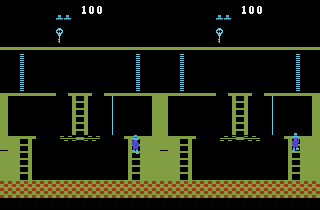

In [214]:
sample = rand(1:1:40)
f1,f2 = first(dtst)[1][sample][1]
both_frames = hcat(f1,f2)
img = permutedims(Float32.(both_frames./255), (3,1,2))

colorview(RGB, img)

In [215]:
first(dtst)[1][sample][2]

"Go to the bottom of the room"

In [216]:
first(dtst)[2][sample] 
#1 true
#2 false

2

In [217]:
argmax(convertsimilaritytoprobdist(b(first(dtst)[1]))[:,sample])

2